In [60]:
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.2.csv'
all_countries_data = pd.read_csv(data_file, dtype={'year': str}, comment='#')
# cast sentence column to string
all_countries_data['sentence'] = all_countries_data['sentence'].astype(str)

In [103]:
# choose a country and year
country = "hungary"
year = "2020"
df = pd.DataFrame(all_countries_data)
country_data = df[(df['year'] == year) & (df['country'] == country)]
# reset index; needed for proper parsing by BERT
country_data = country_data.reset_index(drop=True)
data_len = len(country_data)

In [104]:
# show length of corpus
print(f"corpus size is {data_len} sentences.")
# show first 10 sentences
print(country_data.iloc[:10]['sentence'])

corpus size is 1142 sentences.
0    The National Assembly elects both the presiden...
1    The president’s duties are mainly ceremonial, ...
2    The president is limited to a maximum of two t...
3    János Áder, a founding member of Fidesz, has b...
4    Orbán has been prime minister since 2010, winn...
5    Voters elect representatives every four years ...
6    The coalition of Fidesz and its junior partner...
7    The far-right Movement for a Better Hungary (J...
8    An election-monitoring mission performed by th...
9    While there was no evidence of electoral fraud...
Name: sentence, dtype: object


In [105]:
# load BERT model paraphrase-MiniLM-L3-v2 (multilingual) or all-MiniLM-L6-v2 (english)
# setting min_topic_size to 7 and n_grams from 1 to 3
# we need to explore these parameters. Other parameters:
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html
# guided topic modeling: https://maartengr.github.io/BERTopic/getting_started/guided/guided.html
seed_topic_list = [["corruption"],
                   ["elections", "election", "assembly"],
                  ["freedom", "liberty"]]
model = BERTopic(seed_topic_list=seed_topic_list, verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 7, n_gram_range=(1, 1))
# model = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', min_topic_size = 10, n_gram_range=(1, 3))
# fit model to our data
topics, _ = model.fit_transform(country_data.sentence)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

2023-05-17 14:23:37,507 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-05-17 14:23:39,432 - BERTopic - Reduced dimensionality
2023-05-17 14:23:39,451 - BERTopic - Clustered reduced embeddings


In [106]:
# generate topic-document probability matrix
topic_distr, _ = model.approximate_distribution(country_data.sentence, min_similarity=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.66it/s]


In [107]:
# get topic information
freq = model.get_topic_info()
# print topic information
print(f"Number of topics: {len(freq)}")
print(freq.head())

Number of topics: 35
   Topic  Count                                   Name
0     -1    377                        -1_the_to_in_of
1      0     96  0_media_pluralism_outlets_journalists
2      1     75            1_fidesz_the_opposition_has
3      2     48            2_hungary_nato_eu_hungarian
4      3     46                 3_europe_council_on_of


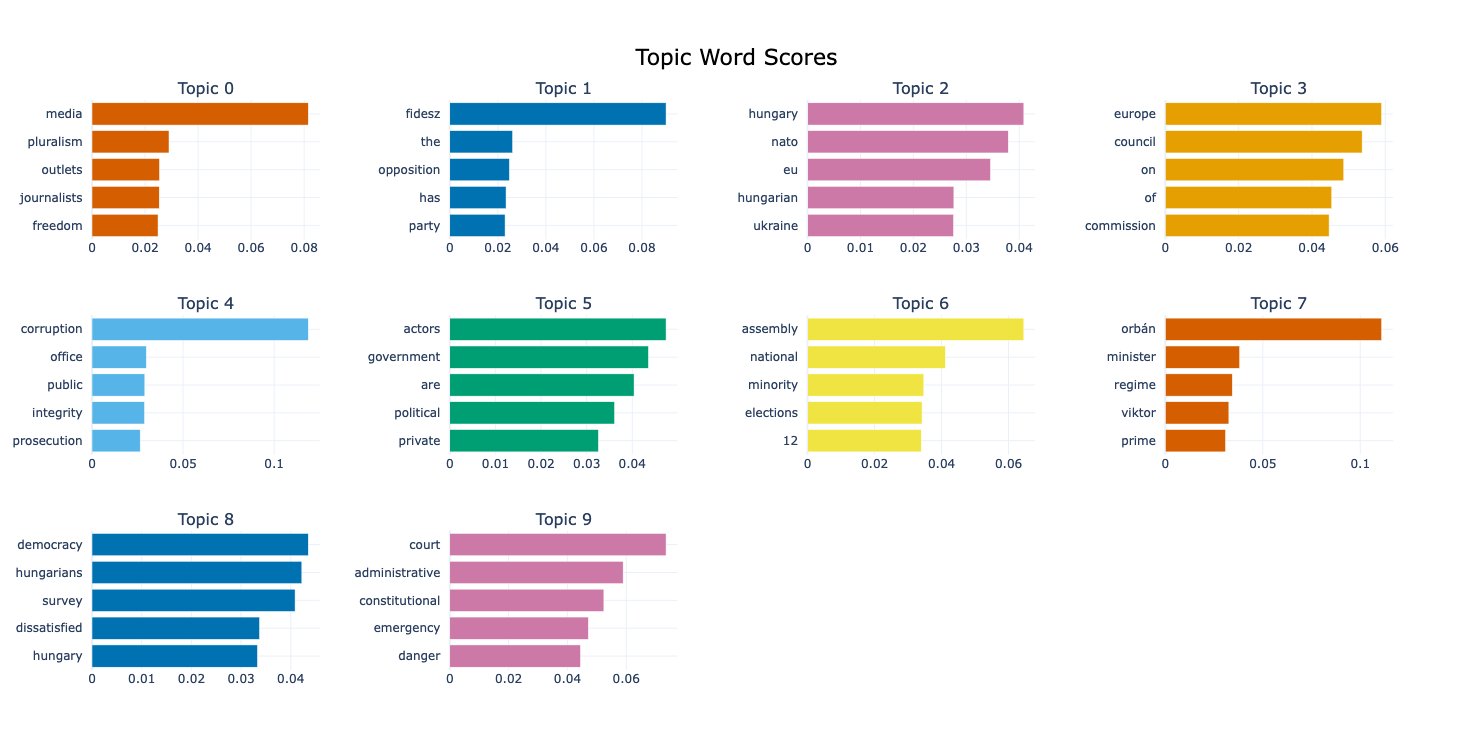

In [108]:
# visualize topic words/n_grams
model.visualize_barchart(top_n_topics=10)

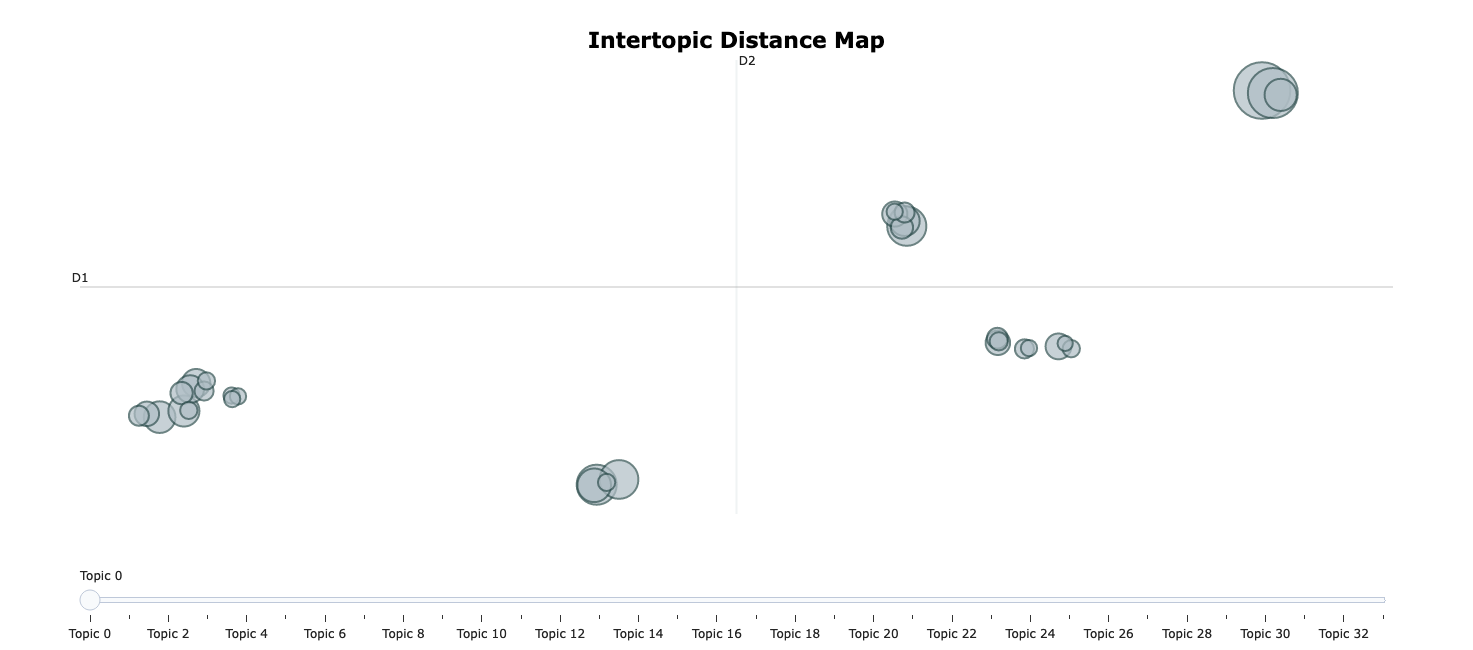

In [109]:
model.visualize_topics()

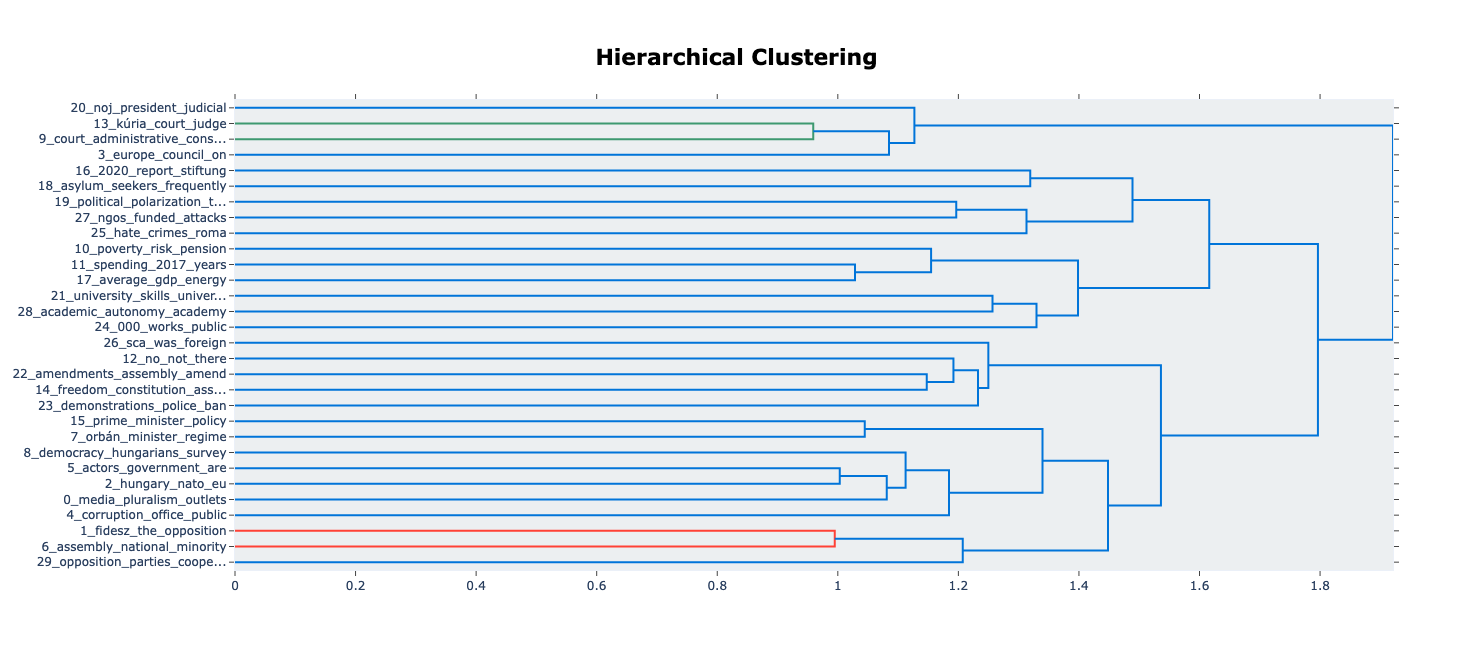

In [110]:
# visualize topic clusters
model.visualize_hierarchy(top_n_topics=30)

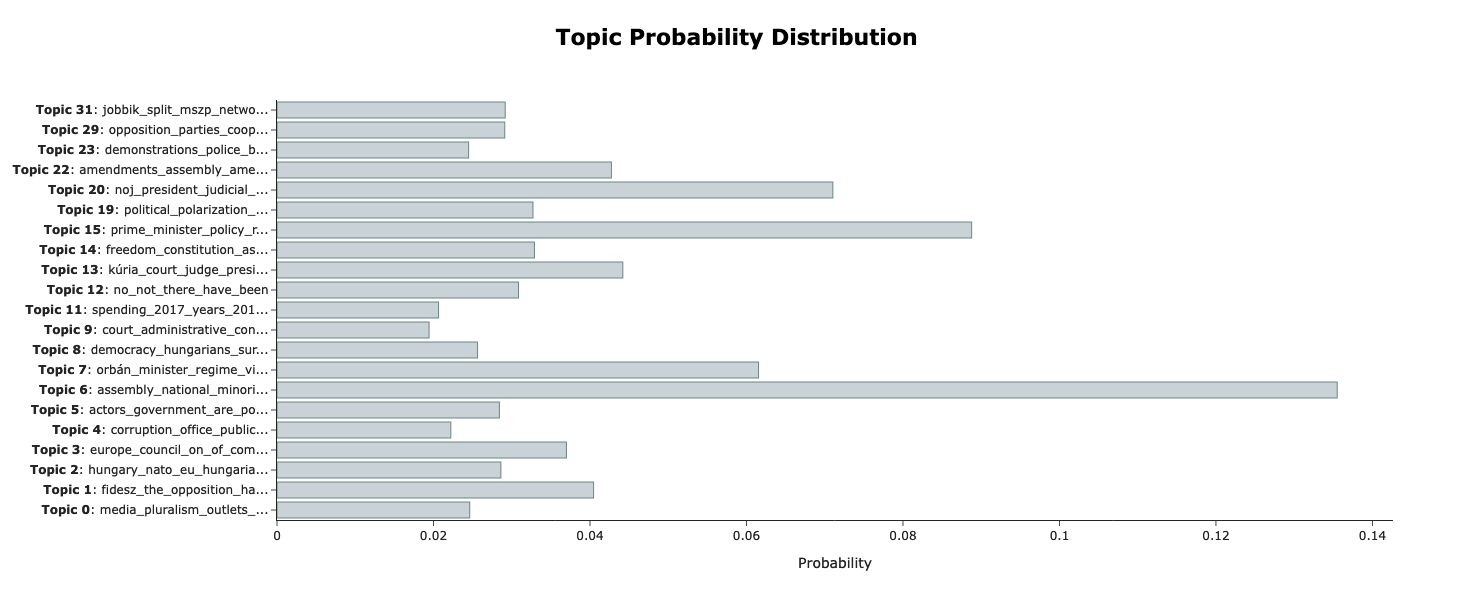

In [111]:
model.visualize_distribution(topic_distr[0])

In [112]:
# search for similar topics
topics = ["freedom", "rule of law", "liberty", "journalism", "pizza"]
for topic in topics:
    similar_topics, similarities = model.find_topics(topic, top_n = 1)
    # most_similar = similar_topics[0]
    print(f"---{topic.upper()}---")
    for most_similar, similarity in zip(similar_topics, similarities):
        print(f"Most Similar Topic Info: {model.get_topic(most_similar)}")
        print(f"Most Similar Topic Number: {most_similar}")
        print(f"Similarity Score: {similarity}")


---FREEDOM---
Most Similar Topic Info: [('freedom', 0.0745905266511672), ('constitution', 0.06803739977540739), ('assembly', 0.03543511696266629), ('generally', 0.03517354445640615), ('rape', 0.03480118860357315), ('abortion', 0.03480118860357315), ('fundamental', 0.034018699887703695), ('guarantees', 0.0324240220944097), ('woman', 0.0324240220944097), ('definition', 0.0324240220944097)]
Most Similar Topic Number: 14
Similarity Score: 0.769198495504604
---RULE OF LAW---
Most Similar Topic Info: [('service', 0.11566357961819256), ('greco', 0.0863497622707262), ('conduct', 0.07838620010569802), ('prosecution', 0.07592299818762466), ('protective', 0.05225746673713202), ('forces', 0.05225746673713202), ('issue', 0.05003946305945459), ('rules', 0.04916692709278755), ('supervision', 0.04822966130975706), ('investigative', 0.04822966130975706)]
Most Similar Topic Number: 30
Similarity Score: 0.4737163347117484
---LIBERTY---
Most Similar Topic Info: [('freedom', 0.0745905266511672), ('constitu

In [113]:
# save model
model.save(f"../data/{country}_{year}")

# loading model
# model=BERTopic.load("../data/file")